## 预测能源效率

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## 下载数据集

In [2]:
data_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
data_path

'C:\\Users\\ChenHao\\.keras\\datasets\\auto-mpg.data'

In [3]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(data_path,names=column_names, 
                          na_values= '?', comment='\t',
                          sep=" ", skipinitialspace=True)
dataset  = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
origin = dataset.pop('Origin')

In [7]:

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin ==2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 拆分数据集

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

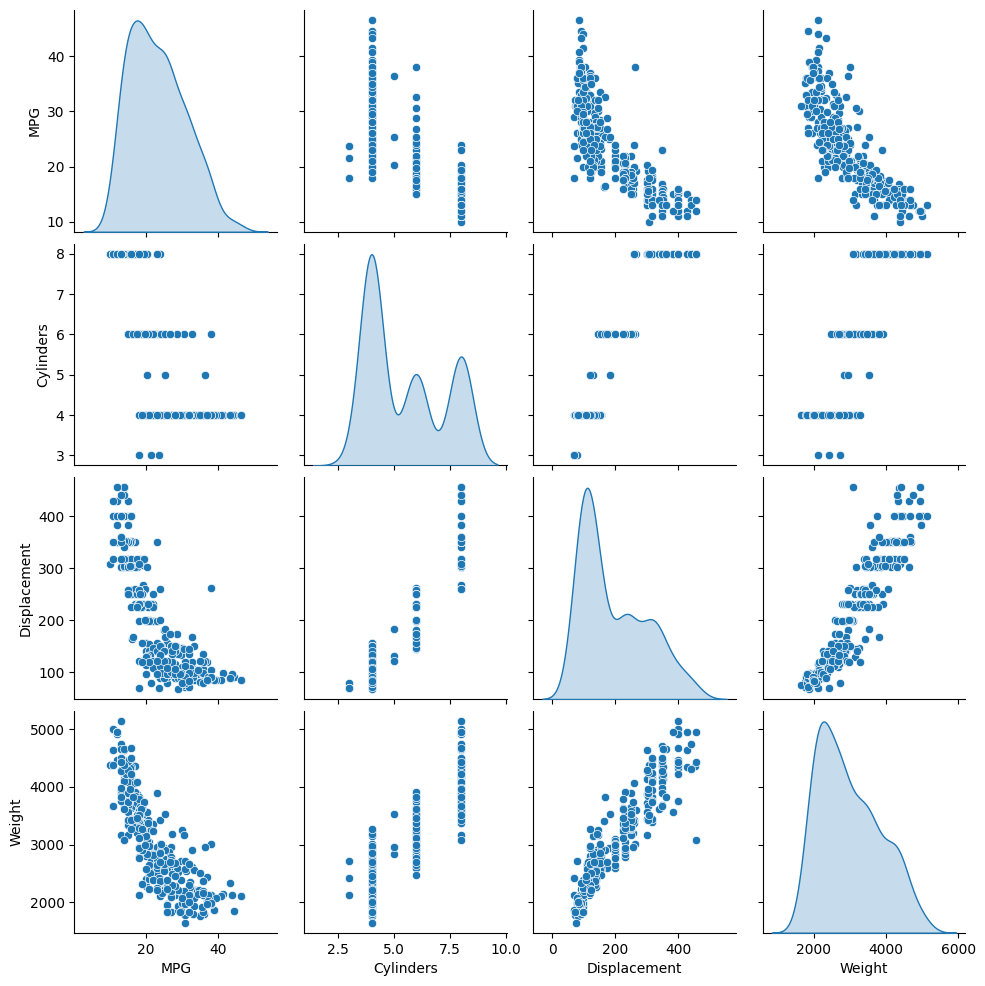

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats
#观察数据分布

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


# 从标签分离特征

In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
## pop 函数会把标签弹出数据帧，数据帧不再包含标签列

In [12]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
## 测试集也使用训练集的归一化数据

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data.tail()
# train_dataset.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852
182,-0.869348,-0.846517,-0.495310,-0.623596,-0.021237,0.027726,-1.286751,2.143005,-0.495225


## 构建模型

In [13]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [14]:
model = build_model()

d:\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
example_batch = normed_train_data[:10]
example_test = model.predict(example_batch)
example_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


array([[-0.34145063],
       [-0.2892899 ],
       [-0.05119261],
       [-0.61639166],
       [-0.07091381],
       [-0.00644005],
       [-0.10924192],
       [-0.20505163],
       [-0.00480913],
       [-0.13892467]], dtype=float32)

In [17]:
## 训练模型

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data,
    train_labels,
    epochs = EPOCHS,
    validation_split = 0.2,
    verbose = 0,
    callbacks = [PrintDot()]
)

..........

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.799681,1.133052,2.799681,8.921499,2.209884,8.921499,995
996,2.675739,1.068185,2.675739,8.965782,2.189829,8.965782,996
997,2.516459,1.030449,2.516459,9.240111,2.235292,9.240111,997
998,2.556399,1.049415,2.556399,9.306402,2.347088,9.306402,998
999,2.614933,1.028776,2.614933,9.253015,2.231806,9.253015,999


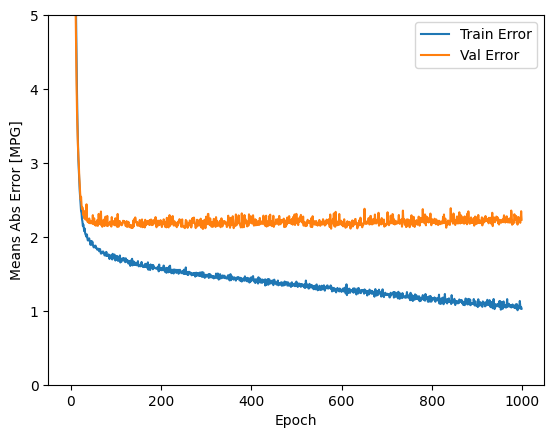

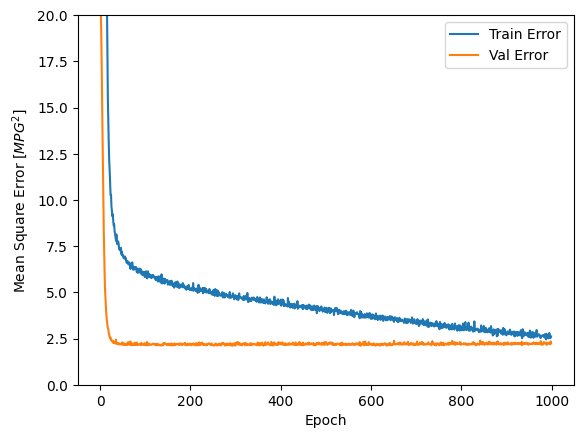

In [20]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Means Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
             label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], 
             label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()
plot_history(history)

d:\Python\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


.

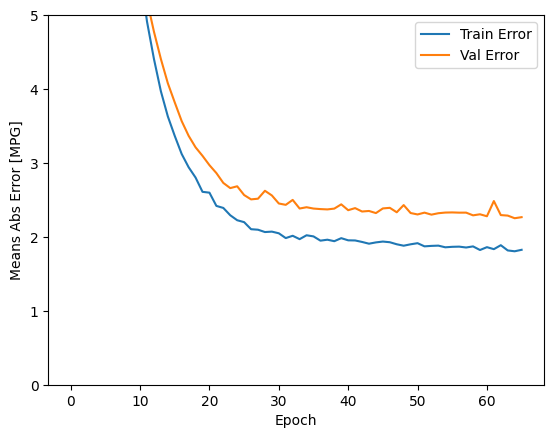

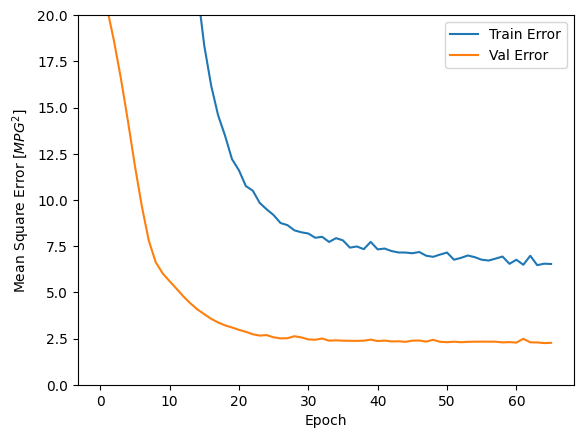

In [21]:
model = build_model()

# early stopping

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks = [early_stop, PrintDot()])
plot_history(history)

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error:{:5.2f} MPG".format(mae))

3/3 - 0s - 14ms/step - loss: 6.6178 - mae: 2.0448 - mse: 6.6178
Testing set Mean Abs Error: 2.04 MPG


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


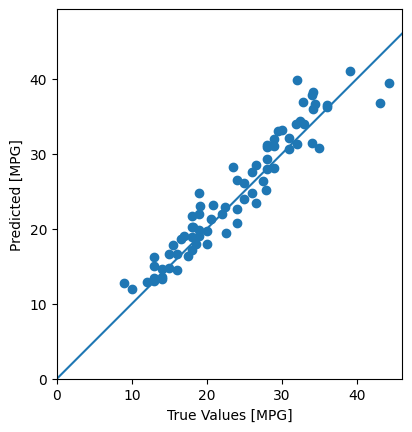

In [23]:
test_predictions  = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predicted [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])

_ = plt.plot([-100, 100], [-100, 100])

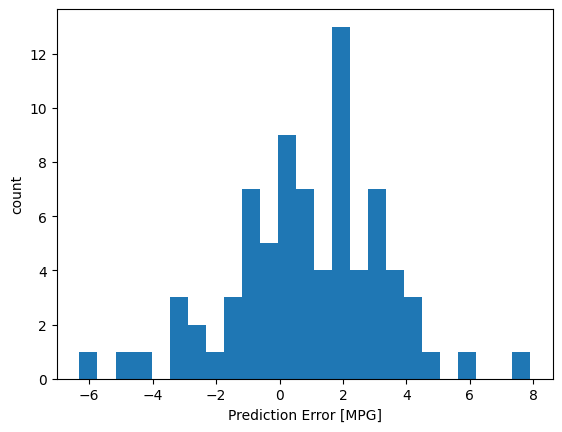

In [26]:
error = test_predictions -test_labels

plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("count")

## 这个笔记利用过往数据预测能源效率，
使用了神经模型使用了三个全连接层，relu 激活函数

此外用 mse 作为 损失函数，